In [1]:
%matplotlib inline
from pylab import *
rcParams['font.size'] = 15
rcParams['legend.fontsize'] = 12

# Set up paths
inputs = eval(open("../inputs.txt").read())
sys.path.insert(0, inputs['CRANE_dir']+'/02_Inference')

In [2]:
# Import Auger_Data for plotting
import Auger_Data

# import an initialize the UHE_fluence class
from Fluence import UHE_fluence
print 'Loading Lookup Table'
f = np.load(inputs['Lookup_Table'])
input_Z = f['input_Z']
input_A = f['input_A']
input_log10_E = f['input_log10_E']
input_log10_z = f['input_log10_z']
observed_log10_E = f['observed_log10_E']
observed_A = f['observed_A']
uhe_LUT = f['LUT']
fcalc = UHE_fluence(input_Z, input_A, input_log10_E, input_log10_z, observed_A, observed_log10_E, uhe_LUT)

# import the likelihood class and initialize the log posterior function
from Likelihood import UHE_likelihood
logposterior = UHE_likelihood(fcalc, ['Auger'])


Loading Lookup Table
Initializing UHE_fluence
Initializing UHE_likelihood


In [3]:
# pick a set of parameters
#fluence_parms = [norm,    spec_in, E_max, f_He,    f_N,     f_Si,    f_Fe,    src_ind, z1,   z2,   z3]
fluence_parms  = [1.33e-62,+2.2,    20.0,  1.11e-04,1.10e-04,1.08e-04,9.92e-02,3.0,     1.87, 2.66, 3.01]
log10_E_shift = -0.01
uX = 0.5 #parameter for Xmax, not used in this estimate.

parms = array([  1.05784496e-62,  +1.94887052e+00,   1.97839165e+01,
         1.17728050e-13,   3.63921110e-06,   2.74058470e-08,
         1.03786965e-01,   2.60923575e+00,   3.98485614e-01,
         4.31577370e-01,   9.64916296e+00,   -0.057,
         9.93218890e-01])

parms = array([  1.77811009e-62,  +2.12101454e+00,   1.99441193e+01,
         9.35089482e-14,   3.44319285e-06,   3.06886530e-08,
         1.12396503e-01,   2.64533730e+00,   3.16234250e-01,
         3.16432308e-01,   9.95448094e+00,  -5.81709756e-02,
         5.93862400e-01])

parms = array([  1.77552978e-62,  +2.10909992e+00,   1.99513215e+01,
         5.33577993e-13,   1.75496183e-06,   5.32062547e-08,
         8.90527170e-02,   2.99616473e+00,   3.11191650e-01,
         3.11192832e-01,   9.99973603e+00,  -6.41190208e-02,
         9.99953603e-01])

parms = array([  1.80204852e-62,   2.17932764e+00,   1.96868785e+01,
         5.36982175e-13,   1.74166628e-06,   5.41096995e-08,
         8.80300445e-02,   3.03064461e+00,   3.09115784e-01,
         3.18266152e-01,   9.99999999e+00,  -6.33503017e-02,
         9.91810755e-01])

parms = array([  1.86281733e-62,   2.27433564e+00,   1.98217387e+01,
         3.48992232e-13,   1.28346020e-06,   3.06111209e-08,
         1.17644772e-01,   4.36356490e+00,   2.89829015e-01,
         2.89829485e-01,   8.57838114e+00,  -5.15494059e-02,
         9.99995621e-01])

fluence_parms = parms[0:11]
log10_E_shift = parms[11]
uX           = parms[12] # ignored in this fit
fluences = fcalc.fluence_model(*fluence_parms)
nuclear_fluence = np.sum(fluences[1:], axis=0)
N_model = Auger_Data.Counts_Model(nuclear_fluence[fcalc.observed_log10_E>18.8999], log10_E_shift = log10_E_shift)

parms = np.concatenate([fluence_parms, [log10_E_shift, uX]])

print parms.shape
lp = logposterior(parms)
print 'Model log-prior',  logposterior.logprior(parms)
print 'Model log-posterior:', lp

(13,)
Model log-prior -0.410386249215
Model log-posterior: -18744.5594223


-0.228
-0.171
-0.114
-0.057


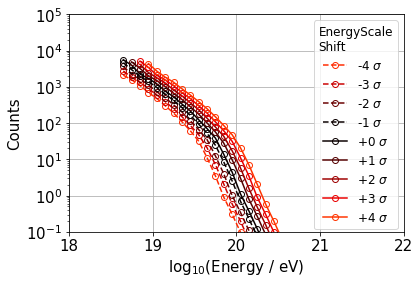

In [4]:
log10_E_array = -np.arange(0.057,4*0.057+0.057/2.,0.057)
cols = cm.hot(np.linspace(0, 1, int(2*len(log10_E_array))))
cc=0
for k in range(0,len(log10_E_array))[::-1]:
    log10_E_shift = log10_E_array[k]
    print log10_E_shift
    N_model = Auger_Data.Counts_Model(nuclear_fluence[fcalc.observed_log10_E>18.599999], log10_E_shift = log10_E_shift)
    semilogy(fcalc.observed_log10_E[fcalc.observed_log10_E>18.5999] + 0.05, N_model, 'o--', color=cols[k], mfc='none', mec=cols[k], label='-%d $\sigma$'%(k+1))
    cc+=1

log10_E_array = +np.arange(0.,5*0.057,0.057)
cols = cm.hot(np.linspace(0, 1, int(2*len(log10_E_array))))
cc=0
for log10_E_shift in log10_E_array:
    N_model = Auger_Data.Counts_Model(nuclear_fluence[fcalc.observed_log10_E>18.599999], log10_E_shift = log10_E_shift)
    semilogy(fcalc.observed_log10_E[fcalc.observed_log10_E>18.5999] + 0.05, N_model, 'o-', color=cols[cc], mfc='none', mec=cols[cc], label='+%d $\sigma$'%(cc))
    cc+=1
lgnd = legend(loc=1, title='EnergyScale\nShift')
plt.setp(lgnd.get_title(),fontsize=12)
grid(True)
ylim(0.1,1.e5)
xlim(18.,22.)
xlabel('log$_{10}$(Energy / eV)')
ylabel('Counts')

N_model = Auger_Data.Counts_Model(nuclear_fluence[fcalc.observed_log10_E>18.599999], log10_E_shift = 0.)


figure()


(18.0, 22.0)

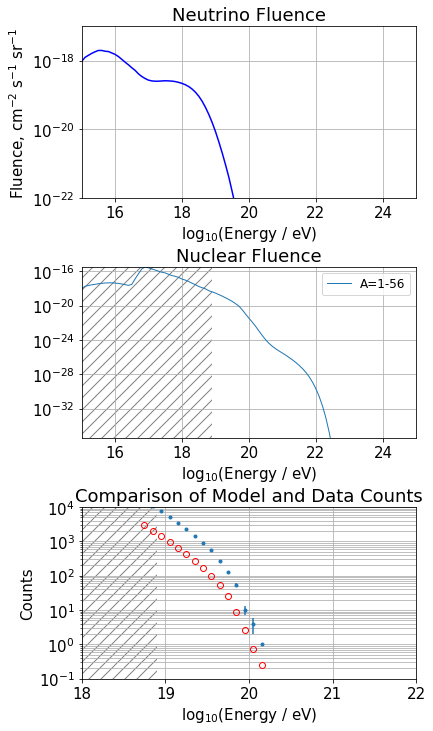

In [5]:
#print input_log10_E
log10_E_shift = parms[11]
N_model = Auger_Data.Counts_Model(nuclear_fluence[fcalc.observed_log10_E>18.6999], log10_E_shift = log10_E_shift)

figure(figsize=(6,12))
ax=subplot(311)
ax.set_yscale('log')
plot(observed_log10_E, fluences[0,:], 'b-')
ylabel('Fluence, cm$^{-2}$ s$^{-1}$ sr$^{-1}$')
xlabel('log$_{10}$(Energy / eV)')
grid(True)
title('Neutrino Fluence')
mx = np.max(fluences[0,:])
y1,y2 = ax.get_ylim()
y2 = 10**np.ceil(np.log10(np.max(fluences[0,:])))
ylim(1.e-5*y2, y2)
xlim(15., 25.)

ax2=subplot(312)
ax2.set_yscale('log')
ax2.plot(observed_log10_E, nuclear_fluence, lw=1, label='A=1-56')
mx = np.max(nuclear_fluence)
ylim(1.e-20*mx, mx)
legend()
xlim(15., 25.)
y1, y2 = ax2.get_ylim()
fill_between([15., 18.9], [y1, y1], [y2,y2], facecolor='none', hatch='//', edgecolor='gray', linewidth=0.0)
title('Nuclear Fluence')
xlabel('log$_{10}$(Energy / eV)')
subplots_adjust(hspace=0.4)
grid(True)

ax3 = subplot(313)
ax3.set_yscale('log')
from scipy.stats import poisson
p_interval =  poisson.interval(0.68, Auger_Data.Counts)
cut = Auger_Data.Counts>0.
errorbar(Auger_Data.log10_Energy_low_edges[cut] + Auger_Data.d_log10_E/2., 
         Auger_Data.Counts[cut], 
         #xerr = 0.05,
         yerr=[Auger_Data.Counts[cut]-p_interval[0][cut], p_interval[1][cut]-Auger_Data.Counts[cut]], 
         fmt='.')
ylim(0.5, 1.e4)
#xticks(np.arange(18.6, 20.2, 0.1), rotation=45)
grid(True, which='both')
ylabel('Counts')
xlabel('log10 (Energy / eV)')
title('Auger Counts by Energy Bin')
plot(fcalc.observed_log10_E[fcalc.observed_log10_E>18.6999] + 0.05, N_model, 'o', mfc='none', mec='r', label='Model')
grid(True, which='both')
y1, y2 = ax3.get_ylim()
y1=0.1
fill_between([15., 18.9], [y1, y1], [y2,y2], facecolor='none', hatch='//', edgecolor='gray', linewidth=0.0)
ylim(y1,y2)
title('Comparison of Model and Data Counts')
xlabel('log$_{10}$(Energy / eV)')
xlim(18.,22.)


In [6]:
# Example of applying minimization to improve the solution (at least locally speaking.)
# initial parameter optimization
def minus_lnprob(_parms):
    LL = logposterior(_parms)
    #'''
    print_str = '%1.2e '%LL
    for k in range(0,len(_parms)):
        print_str += '%+1.1e '%_parms[k]
    # print the values occasionally
    if(np.random.randint(0,100)==0): print print_str
    #'''
    return -1.*LL

from scipy.optimize import minimize
res = minimize(minus_lnprob, parms, method='nelder-mead', options={'xtol': 1e-3, 'disp': True})
print res
initial_parm_vals = res.x
print 'DONE MINIMIZING'


-3.12e+02 +2.0e-62 +1.8e+00 +1.9e+01 +3.6e-13 +1.3e-06 +3.1e-08 +1.2e-01 +4.7e+00 +2.9e-01 +3.1e-01 +8.7e+00 -5.2e-02 +9.6e-01 
-5.11e+01 +2.0e-62 +1.8e+00 +2.0e+01 +3.6e-13 +1.3e-06 +3.1e-08 +1.2e-01 +4.8e+00 +2.9e-01 +3.1e-01 +8.6e+00 -5.2e-02 +9.6e-01 
-5.07e+01 +2.0e-62 +1.8e+00 +2.0e+01 +3.6e-13 +1.3e-06 +3.1e-08 +1.2e-01 +4.8e+00 +2.9e-01 +3.1e-01 +8.6e+00 -5.2e-02 +9.6e-01 
-inf +1.7e-62 +1.8e+00 +2.0e+01 +2.9e-13 +1.3e-06 +3.1e-08 +1.2e-01 +5.9e+00 +3.0e-01 +3.0e-01 +8.6e+00 -5.4e-02 +9.9e-01 
-inf +1.7e-62 +1.8e+00 +2.0e+01 +2.9e-13 +1.3e-06 +3.1e-08 +1.2e-01 +5.9e+00 +3.0e-01 +3.0e-01 +8.7e+00 -5.4e-02 +9.9e-01 
-3.88e+01 +1.7e-62 +1.8e+00 +2.0e+01 +2.8e-13 +1.3e-06 +3.1e-08 +1.2e-01 +5.9e+00 +3.0e-01 +3.0e-01 +8.7e+00 -5.4e-02 +1.0e+00 
-3.88e+01 +1.7e-62 +1.8e+00 +2.0e+01 +2.8e-13 +1.3e-06 +3.1e-08 +1.2e-01 +5.9e+00 +3.0e-01 +3.0e-01 +8.7e+00 -5.5e-02 +1.0e+00 
-inf +1.7e-62 +1.8e+00 +2.0e+01 +2.8e-13 +1.3e-06 +3.1e-08 +1.2e-01 +6.0e+00 +3.0e-01 +3.0e-01 +8.7e+00 -5.5e-02 +

Maximum Likelihood Parameters
norm	9.50e-63
spectral_index	1.82
log10_E_max	19.90
f_p	0.8609
f_He	0.0000
f_N	0.0000
f_Si	0.0000
f_Fe	0.1391
source_index	8.86
z1	0.29
z2	0.31
z3	8.76
----------
log10_E_shift	-0.058
Model log-posterior: -23.801387872


(18.0, 22.0)

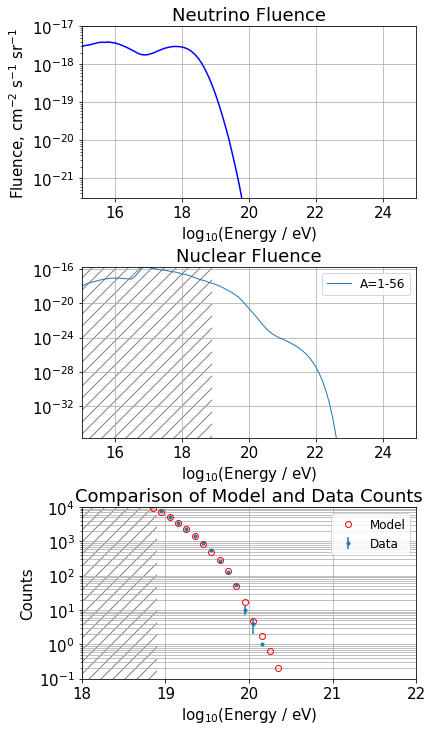

In [7]:
print 'Maximum Likelihood Parameters'
parms = res.x
print 'norm\t%1.2e'%parms[0] 
print 'spectral_index\t%1.2f'%parms[1] 
print 'log10_E_max\t%1.2f'%parms[2]
print 'f_p\t%1.4f'%(1. - np.sum(parms[3:7]))
print 'f_He\t%1.4f'%parms[3]
print 'f_N\t%1.4f'%parms[4]
print 'f_Si\t%1.4f'%parms[5]
print 'f_Fe\t%1.4f'%parms[6]
print 'source_index\t%1.2f'%parms[7]
print 'z1\t%1.2f'%parms[8]
print 'z2\t%1.2f'%parms[9]
print 'z3\t%1.2f'%parms[10]
print '----------'
print 'log10_E_shift\t%1.3f'%parms[11]
fluences = fcalc.fluence_model(*parms[0:11])
nuclear_fluence = np.sum(fluences[1:], axis=0)
N_model = Auger_Data.Counts_Model(nuclear_fluence[fcalc.observed_log10_E>18.6999], parms[11])

lp = logposterior(res.x)
print 'Model log-posterior:', lp

#print input_log10_E

figure(figsize=(6,12))
ax=subplot(311)
ax.set_yscale('log')
plot(observed_log10_E, fluences[0,:], 'b-')
ylabel('Fluence, cm$^{-2}$ s$^{-1}$ sr$^{-1}$')
xlabel('log$_{10}$(Energy / eV)')
grid(True)
title('Neutrino Fluence')
mx = np.max(fluences[0,:])
y1, y2 = ax.get_ylim()
y2 = 10**np.ceil(np.log10(np.max(fluences[0,:])))
ylim(3.e-5*y2, y2)
xlim(15., 25.)

ax2=subplot(312)
ax2.set_yscale('log')
ax2.plot(observed_log10_E, nuclear_fluence, lw=1, label='A=1-56')
mx = np.max(nuclear_fluence)
ylim(1.e-20*mx, mx)
legend()
xlim(15., 25.)
y1, y2 = ax2.get_ylim()
fill_between([15., 18.9], [y1, y1], [y2,y2], facecolor='none', hatch='//', edgecolor='gray', linewidth=0.0)
title('Nuclear Fluence')
xlabel('log$_{10}$(Energy / eV)')
subplots_adjust(hspace=0.4)
grid(True)

ax3 = subplot(313)
ax3.set_yscale('log')
from scipy.stats import poisson
p_interval =  poisson.interval(0.68, Auger_Data.Counts)
cut = Auger_Data.Counts>0.
errorbar(Auger_Data.log10_Energy_low_edges[cut] + Auger_Data.d_log10_E/2., 
         Auger_Data.Counts[cut], 
         #xerr = 0.05,
         yerr=[Auger_Data.Counts[cut]-p_interval[0][cut], p_interval[1][cut]-Auger_Data.Counts[cut]], 
         fmt='.',
         label='Data')
ylim(0.5, 1.e4)
#xticks(np.arange(18.6, 20.2, 0.1), rotation=45)
grid(True, which='both')
ylabel('Counts')
xlabel('log10 (Energy / eV)')
title('Auger Counts by Energy Bin')
plot(fcalc.observed_log10_E[fcalc.observed_log10_E>18.6999] + 0.05, N_model, 'o', mfc='none', mec='r', label='Model')
grid(True, which='both')
y1, y2 = ax3.get_ylim()
y1=0.1
fill_between([15., 18.9], [y1, y1], [y2,y2], facecolor='none', hatch='//', edgecolor='gray', linewidth=0.0)
ylim(y1,y2)
title('Comparison of Model and Data Counts')
xlabel('log$_{10}$(Energy / eV)')
legend()
xlim(18.,22.)

